# <span style="color:orange; font-weight:bold">DEEP LEARNING MINI PROJECT CS60010<br>SPRING SEMESTER 2023 - 2024 IIT KHARAGPUR</span>

## <span style="color:violet; font-weight:bold">Task: Build encoder decoder models for Automatic Image Captioning</span>
## <span style="color:violet; font-weight:bold">Part B : Transformer based encoder decoder model using a Vision Transformer (ViT)</span>
## Group 26 Team members:
### - **Rajanyo Paul - 23CS60R82**
### - **Dipan Mandal - 23CS60R04**
### - **Avik Pramanick - 23CS60R78**
### - **Soham Banerjee - 23CS60R42**


In [2]:
# !pip install torch
# !pip install nltk
# !pip install transformers 
# !pip install torchvision
# !pip install rouge
# !pip install git+https://github.com/salaniz/pycocoevalcap

In [4]:
import os
import nltk
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
nltk.download('punkt')
from rouge import Rouge
from torch.nn import CrossEntropyLoss
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, Dataset
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from ipywidgets import Dropdown, Output, VBox
from transformers import ViTModel, GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoImageProcessor,AutoModelForImageClassification

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Preprocessing
### This is the first part of the assignment that includes data parsing and formatting. For that we have implemented...

**class CustomDataset** : Loads the images & their respective captions using 'load_csv()' and then builds the vocabulary, transforms the image and tokenizes the caption to tensor format and returns them.

**load_csv()** : Given the parent folder and the sub folder name it loads the respective csv file.

**transform_image()** : Resizes and transforms the given image to tensor format.



In [5]:
def load_csv(data_folder, data_type ='train'):
    csv_file_path = os.path.join(data_folder, f'{data_type}.csv')
    return pd.read_csv(csv_file_path)

In [6]:
def transform_image():
    return transforms.Compose([transforms.Resize((224, 224), antialias = True),
                               transforms.ToTensor(),
                               transforms.RandomHorizontalFlip()])

This below class "CustomDataset" unlike that of part A integrates a pre-trained Vision Transformer (ViT) model (WinKawaks/vit-small-patch16-224) to process images. This processor converts images into a format suitable for the model (i.e., tensor of pixel values).

Then the tokenizer utilizes a GPT2 tokenizer to convert captions into tokens, setting the padding token to be the same as the end-of-sequence (EOS) token to handle variable caption lengths appropriately.


In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, dataset_type = 'train'):
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.data_frame = load_csv(root_dir, dataset_type)
        
        self.processor = AutoImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")
        
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.transform = transform_image()
        
        self.imgs = self.data_frame['filename']    # Getting image and caption columns
        self.captions = self.data_frame['caption']

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img_folder = os.path.join(self.root_dir, self.dataset_type)
        img_path = os.path.join(img_folder, img_id)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            image = self.transform(image)
        
        # Gettiing features from images and tokenizing the captions
        inputs = self.processor(images = image, return_tensors = "pt").pixel_values[0]
        tokens = self.tokenizer(caption, padding = 'max_length', max_length = 130, truncation = True, return_tensors = "pt")
        
        return inputs, tokens.input_ids.squeeze(), tokens.attention_mask.squeeze()


# 2. Model Creation
In our Encoder_Decoder class, we start by extracting image features from the "[CLS]" token of a Vision Transformer (ViT), which is designed to capture the global context of the image. These features are then transformed to match the embedding size required by GPT-2 through a linear transformation layer called feature_to_input. Normally, GPT-2 expects embeddings of 768 dimensions, but to optimize GPU memory usage and avoid overloading, we've adjusted this to 480 dimensions. We treat these adjusted image features as the initial token in a sequence and prepend them to the text token embeddings. This combined sequence—beginning with image-derived features followed by textual tokens—is processed by GPT-2. We also extend the attention mask to accommodate this additional initial token when present, ensuring the attention mechanism in GPT-2 functions correctly across the entire sequence. This integration of visual and textual data enables our model to generate contextually accurate captions, efficiently leveraging both image and text inputs.
After our model class is prepared we make the dataloaders for train, test and validation sets.

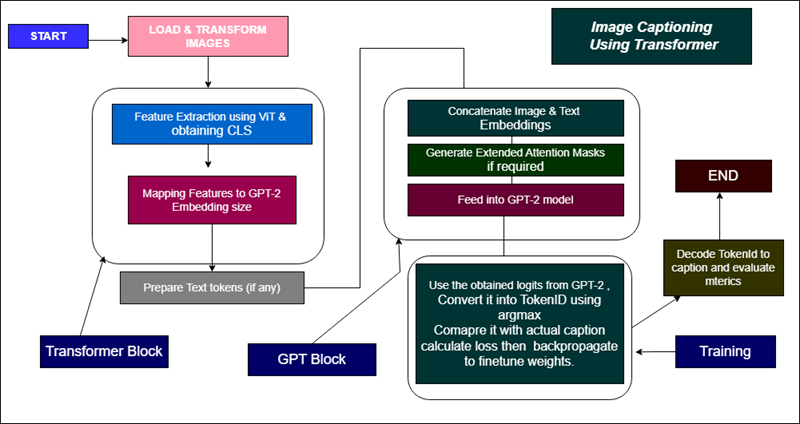

Made using : https://app.diagrams.net/

In [8]:
class Encoder_Decoder(nn.Module):
    def __init__(self):
        super(Encoder_Decoder, self).__init__()
        self.feature_dim = 480
        self.vit = ViTModel.from_pretrained('WinKawaks/vit-small-patch16-224')   # Vision Transformer model
        self.gpt2_config = GPT2Config.from_pretrained('gpt2')                    # GPT-2 model configuration
        self.gpt2_config.n_embd = self.feature_dim
        self.gpt2 = GPT2LMHeadModel(self.gpt2_config)
        
        # A linear layer to map ViT features to GPT-2 input dimensions
        self.feature_to_input = nn.Linear(self.vit.config.hidden_size, self.gpt2_config.n_embd)
        
    def forward(self, pixel_values, input_ids, attention_mask=None):
        # Extracting the features from the image using ViT
        vit_outputs = self.vit(pixel_values = pixel_values)
        vit_features = vit_outputs.last_hidden_state[:, 0, :]  # Using the [CLS] token's features

        # Mapping ViT features to the GPT-2 embedding size
        gpt2_input_features = self.feature_to_input(vit_features).unsqueeze(1)  # Add sequence dimension

        # Embedding the input_ids using GPT-2 embeddings
        input_embeddings = self.gpt2.transformer.wte(input_ids)  # Using GPT-2's embedding matrix

        # Prepending the image features to the text embeddings
        extended_input_embeddings = torch.cat((gpt2_input_features, input_embeddings), dim=1)

        # Extend the attention mask by one to account for the additional initial token
        if attention_mask is not None:
            initial_token_mask = torch.ones((attention_mask.shape[0], 1), device = attention_mask.device, dtype = torch.long)
            extended_attention_mask = torch.cat([initial_token_mask, attention_mask], dim = 1)
        else:
            extended_attention_mask = None

        # Process with GPT-2
        gpt2_outputs = self.gpt2(inputs_embeds = extended_input_embeddings, attention_mask = extended_attention_mask)
        return gpt2_outputs

In [10]:
root_dir = '/kaggle/input/dataset-zipped/custom_captions_dataset'

   # Preparing the dataseta and dataloader for training
train_dataset = CustomDataset(root_dir = root_dir, dataset_type = 'train')
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

   # Preparing the dataseta and dataloader for validation
val_dataset = CustomDataset(root_dir = root_dir, dataset_type = 'val')
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)

   # Preparing the dataseta and dataloader for validation
test_dataset = CustomDataset(root_dir = root_dir, dataset_type = 'test')
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

# 3. Setting the criteria for loss, initializingmodel object then beginning the training process.
We have configured our model to run on a GPU if available. We optimize their parameters using AdamW with a learning rate of 3e-4 and train for 10 epochs. We use a custom loss function to compute the cross-entropy loss between the predicted output and the actual captions. We start by shifting the logits and labels to exclude the first token from the labels, aligning them for accurate comparison. This ensures we're calculating the loss only for the generated parts of the captions, not the initial image features. We then flatten these tensors to convert the 2D outputs into a 1D array suitable for the loss calculation. Finally, we apply the cross_entropy_loss function to compute the loss, which quantifies how well our model's predictions match the true captions, guiding the optimization of model parameters during training.   

Here, "logits" are the raw output values from the model before applying the softmax function  &  "labels" are the actual numericalized tokens of the captions that the model is trying to predict

We use AdamW instead of traditional Adam as it applies weight decay directly to the weights rather than during the gradient update, which enhances training stability and performance. This method is particularly effective in fine-tuning complex models, ensuring optimal adjustments to the pre-trained weights. We took its reference from : https://towardsdatascience.com/why-adamw-matters-736223f31b5d

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initializing the model, optimizer, and the loss function
model = Encoder_Decoder().to(device)
optimizer = optim.AdamW(model.parameters(), lr = 3e-4)
cross_entropy_loss = nn.CrossEntropyLoss()
num_epoch = 10

def calculate_loss(outputs, labels):
    shift_logits = outputs[:, :-1, :]
    shift_labels = labels[:, 1:]   # Removing the first token from labels
    
    # Ensuring that the lengths of shift_logits and shift_labels match
    min_length = min(shift_logits.size(1), shift_labels.size(1))
    shift_logits = shift_logits[:, :min_length]
    shift_labels = shift_labels[:, :min_length]
    
    # Flattening the logits and labels tensors
    shift_logits_flat = shift_logits.reshape(-1, shift_logits.size(-1))
    shift_labels_flat = shift_labels.reshape(-1)
    
    # Calculate the cross-entropy loss
    loss = cross_entropy_loss(shift_logits_flat, shift_labels_flat)
    return loss

for epoch in range(num_epoch):
    model.train()
    total_training_loss = 0.0
    
    # Training Phase
    for pixel_values, input_ids, attention_mask in train_loader:
        pixel_values, input_ids, attention_mask = pixel_values.to(device), input_ids.to(device), attention_mask.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values = pixel_values, input_ids = input_ids, attention_mask = attention_mask).logits
        loss = calculate_loss(outputs, input_ids)
        loss.backward()
        optimizer.step()
        total_training_loss += loss.item()
    
    avg_training_loss = total_training_loss / len(train_loader)
    
    # Validation Phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for pixel_values, input_ids, attention_mask in val_loader:
            pixel_values, input_ids, attention_mask = pixel_values.to(device), input_ids.to(device), attention_mask.to(device)
            outputs = model(pixel_values = pixel_values, input_ids = input_ids, attention_mask = attention_mask).logits
            loss = calculate_loss(outputs, input_ids)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    
    print(f'Epoch [{epoch + 1}/{num_epoch}], Training Loss: {avg_training_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch [1/10], Training Loss: 3.1607, Validation Loss: 2.8512
Epoch [2/10], Training Loss: 2.6592, Validation Loss: 2.6050
Epoch [3/10], Training Loss: 2.4456, Validation Loss: 2.4711
Epoch [4/10], Training Loss: 2.2983, Validation Loss: 2.3842
Epoch [5/10], Training Loss: 2.1885, Validation Loss: 2.3383
Epoch [6/10], Training Loss: 2.0972, Validation Loss: 2.3109
Epoch [7/10], Training Loss: 2.0150, Validation Loss: 2.3048
Epoch [8/10], Training Loss: 1.9427, Validation Loss: 2.3121
Epoch [9/10], Training Loss: 1.8751, Validation Loss: 2.3164
Epoch [10/10], Training Loss: 1.8053, Validation Loss: 2.3353


# 4. Model Evaluation on the Test set
For this first we fetch the actual test set captions in a list named "actual_test_captions", then we wrote a function that generates predicted captions and stores them in "predicted_test_captions". Then the metrics evaluation is performed.

In [32]:
def load_reference_captions(csv_file_path):
    df = pd.read_csv(csv_file_path)
    captions = df['caption'].tolist()
    return captions

# Path to the test.csv
csv_file_path = '/kaggle/input/dataset-zipped/custom_captions_dataset/test.csv'
actual_test_captions = load_reference_captions(csv_file_path)

In [33]:
print("Let's see the actual first five captions related to test set\n")
for i in range(5):
    print(f'Actual caption {i+1} : {actual_test_captions[i]}\n')

Let's see the actual first five captions related to test set

Actual caption 1 : A large building with bars on the windows in front of it. There is people walking in front of the building. There is a street in front of the building with many cars on it. 

Actual caption 2 : A person is skiing through the snow. There is loose snow all around them from him jumping. The person is wearing a yellow snow suit. The person is holding two ski poles in their hands. 

Actual caption 3 : There is a bed in a room against a wall. There is a brown blanket on top of the bed. There is a small brown book shelf next to the bed. There is a picture hanging on the wall above the shelf. 

Actual caption 4 : A black and red train is on the tracks and has steam coming out off of it. There is another train next to the first train that is orange. There is an overpass over the train tracks with cars on it. 

Actual caption 5 : A white and yellow public transportation bus with "122" on front is stopped with it's d

In [12]:
def generate_captions_for_test_set(model, tokenizer, loader):
    model.eval()
    captions = []

    with torch.no_grad():
        for pixel_values, input_ids, attention_mask in loader:
            pixel_values = pixel_values.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(pixel_values = pixel_values, input_ids = input_ids, attention_mask = attention_mask).logits

            # Convert output logits to token ids
            predicted_ids = torch.argmax(outputs, dim = -1)
            
            # Decode the token ids to get the captions
            for ids in predicted_ids:
                # Decode each sequence, skipping the first token (as it is for image features)
                caption = tokenizer.decode(ids[1:], skip_special_tokens = True)
                captions.append(caption)
                
    return captions

# Generate captions on the test set
predicted_test_captions = generate_captions_for_test_set(model, train_dataset.tokenizer, test_loader)


In [13]:
# Lets see if it is able to generate caption for every image in test set

flag = 0
for i in range(len(predicted_test_captions)):
    if predicted_test_captions[i] == '':
        print(f'No caption for test image {i+1}')
        flag = 1
        break
if flag == 0:
    print('Caption present for every test image...')

Caption present for every test image...


### Printing the metric values, the metrics CIDEr and SPICE use a special format
### That is a dictionary that has the key/index as image name and key-value as a list of caption(s) for that image

In [36]:
def tweak_data():
    captions_predicted = {}
    captions_actual = {}
    for index, (predicted, actual) in enumerate(zip(predicted_test_captions, actual_test_captions)):
        image_id = str(index)
        captions_predicted[image_id] = [predicted]
        captions_actual[image_id] = [actual]
    
    return captions_predicted, captions_actual


def evaluate_metrics():
    
    # First let's do ROUGE-L
    rouge = Rouge()
    scores = rouge.get_scores(predicted_test_captions, actual_test_captions, avg = True)
    rouge_l_score = scores['rouge-l']['f']
    
    # For CIDEr and SPICE we need a teeny tiny tweaking in sending the actual captions and predicted captions
    # Doing that first...
    print('\nLoading some resources...')
    predicted_captions , actual_captions = tweak_data()
    cider_scorer = Cider()
    spice_scorer = Spice()
    
    cider_score, _ = cider_scorer.compute_score(actual_captions, predicted_captions)
    spice_score, _ = spice_scorer.compute_score(actual_captions, predicted_captions)
    
    return rouge_l_score, cider_score, spice_score

In [37]:
rouge_score, cider_score, spice_score = evaluate_metrics()
print('\n\nThe metrics after evaluation are...')
print(f'\nThe ROUGE-L score is : {rouge_score}\n')
print(f'The CIDEr score is: {cider_score}\n')
print(f'The SPICE score is: {spice_score}')   


Loading some resources...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classif

SPICE evaluation took: 2.377 min


The metrics after evaluation are...

The ROUGE-L score is : 0.3971661692771957

The CIDEr score is: 0.3354663638540146

The SPICE score is: 0.13363108855120315


## Now taking an image input from user and giving away its generated caption for output

In [14]:
# For transforming one image that is selected
transform_one = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# If you change the last value test with train or val then it will choose from those sets
dataset_path = '/kaggle/input/dataset-zipped/custom_captions_dataset/test'
image_files = os.listdir(dataset_path)
image_files.sort()


def handle_image_file(change):

    image_path = os.path.join(dataset_path, change['new'])
    image_number = int(image_path.split('/')[-1].split('_')[1].split('.')[0]) - 1
    
    with output:
        output.clear_output()
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        print("Output :", predicted_test_captions[image_number])
        
dropdown = Dropdown(options = image_files, description = "Select Image:")
output = Output()
dropdown.observe(handle_image_file, names = 'value')
display(VBox([dropdown, output]))

### As mentioned the  last cell has the generated captions from the test set

In [38]:
for idx, caption in enumerate(predicted_test_captions):
    print(f"Generated Caption for test image {idx+1}: {caption}")

Generated Caption for test image 1:  is is a windows the side of it of it. There The a large on the of the building. There is a man on front of the building.  on on it. There
Generated Caption for test image 2:  is a on a snow. The is snow person on the the person a left a the is is wearing a black shirt and. a is is wearing a ski poles in to hand. There
Generated Caption for test image 3:  a white on a room. There wall. There is a white on on the of the bed. There is a white on on on to to the bed.  a white on the the wall next the bed. There
Generated Caption for test image 4:  is white train is on the tracks tracks There. on it of it it. There is a white on on the train.. There located on black a on on train the..  on it. 
Generated Caption for test image 5:  is is train is train is parked yellow" parked it side it on a red a.   to a large sign on the side of and bus. In the bus is a a building light light a windows of" on Above on it the side of. There the
Generated Caption for tes